In [18]:
import warnings
from typing import Any
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score, auc
from sklearn.feature_selection import RFECV
import optuna
import optuna.trial
import optuna.logging

from utils import plot_roc
import ml_utils as utils
from ml_utils import (
    get_weights_for_roc_auc, weighted_roc_metric, weighted_fpr_roc_metric, 
    get_optimal_trs, plot_roc, get_tpr_fpr, plot_roc_curves
)
import train


np.random.seed(42)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# aft, magn > 3.5

## read 

In [2]:
dataset_type_train = "magn_3_5_aft_train"
dataset_type_test = "magn_3_5_aft_test"

target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

train_path = f"data/dataset/{dataset_type_train}.parquet"
test_path = f"data/dataset/{dataset_type_test}.parquet"

In [3]:
train_df, test_df = utils.get_train_test_datasets(
    train_path=train_path, test_path=test_path, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

train_path: data/dataset/magn_3_5_aft_train.parquet
test_path: data/dataset/magn_3_5_aft_test.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-21 — 2020-08-26
test dates: 2020-10-14 — 2023-05-21

train: target==0: 1593709, target==1: 27847
test: target==0: 6428932, target==1: 98518
target class proportion: test: 0.015324162706962836, train: 0.01747307695445028


In [4]:
feature_cols = list(set(train_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

In [5]:
# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_train, y_train = features.make_features_target(train_df)
X_test, y_test = features.make_features_target(test_df)

In [6]:
y_test.reset_index().merge(y_train.reset_index(), how="left").isna().sum()

dt        0
cell_x    0
cell_y    0
target    0
dtype: int64

In [7]:
# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date)
roc_auc_weights_train = get_weights_for_roc_auc(y=y_train, last_dt=min_test_date)

In [8]:
assert len(roc_auc_weights_test) == len(roc_auc_weights_test[~np.isnan(roc_auc_weights_test)]) == len(y_test)
assert len(roc_auc_weights_train) == len(roc_auc_weights_train[~np.isnan(roc_auc_weights_train)]) == len(y_train)

In [9]:
roc_auc_weights_test

array([0.08894231, 0.08894231, 0.08894231, ..., 0.00240385, 0.00240385,
       0.00240385])

In [10]:
len(roc_auc_weights_test[roc_auc_weights_test > 0.0]), np.max(roc_auc_weights_test), np.unique(roc_auc_weights_test)

(6527450,
 1.0,
 array([0.00240385, 0.00480769, 0.00721154, 0.00961538, 0.01201923,
        0.01442308, 0.01682692, 0.01923077, 0.02163462, 0.02403846,
        0.02644231, 0.02884615, 0.03125   , 0.03365385, 0.03605769,
        0.03846154, 0.04086538, 0.04326923, 0.04567308, 0.04807692,
        0.05048077, 0.05288462, 0.05528846, 0.05769231, 0.06009615,
        0.0625    , 0.06490385, 0.06730769, 0.06971154, 0.07211538,
        0.07451923, 0.07692308, 0.07932692, 0.08173077, 0.08413462,
        0.08653846, 0.08894231, 0.09134615, 0.09375   , 0.09615385,
        0.09855769, 0.10096154, 0.10336538, 0.10576923, 0.10817308,
        0.11057692, 0.11298077, 0.11538462, 0.11778846, 0.12019231,
        0.12259615, 0.125     , 0.12740385, 0.12980769, 0.13221154,
        0.13461538, 0.13701923, 0.13942308, 0.14182692, 0.14423077,
        0.14663462, 0.14903846, 0.15144231, 0.15384615, 0.15625   ,
        0.15865385, 0.16105769, 0.16346154, 0.16586538, 0.16826923,
        0.17067308, 0.17307692, 

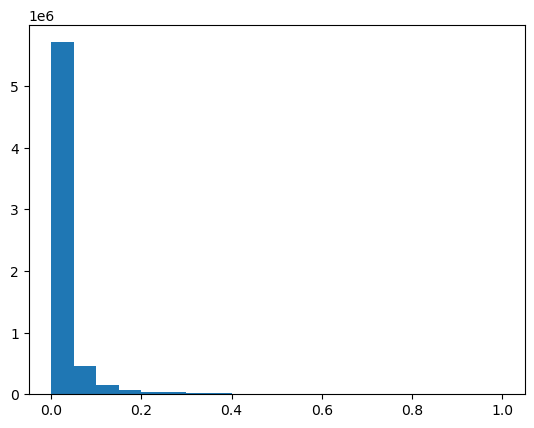

In [11]:
plt.hist(roc_auc_weights_test[roc_auc_weights_test > 0.0], range=(0, 1.0), bins=20);

In [12]:
y_train = y_train[target]
y_test = y_test[target]

In [13]:
y_train.sum(), y_test.sum()

(27847, 98518)

## logreg

In [14]:
cv = utils.MonthlyTimeSeriesSplit(window=20)
cv.get_n_splits(X_train)

3

In [15]:
for split_train, split_test in cv.split(X_train):
    train_start = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    train_end = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]
    test_start = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    test_end = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]

    print(f"train: [{train_start}, {train_end}], len: {len(split_train)} | test: [{test_start}, {test_end}], len: {len(split_test)}")

train: [2014-03-21, 2015-10-22], len: 405389 | test: [2015-11-01, 2017-06-23], len: 419131
train: [2014-03-21, 2017-06-23], len: 824520 | test: [2017-07-03, 2019-02-23], len: 419131
train: [2014-03-21, 2019-02-23], len: 1243651 | test: [2019-03-05, 2020-08-26], len: 377905


### baseline

In [16]:
params = {
    "C": 1.0,
    "max_iter": 1500,
}

logreg_model = train.get_logreg_model(feature_cols, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)

baseline_roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

(0.7377613785149053,
 0.7073549348098119,
 '----',
 0.7837444932851705,
 0.816802848290178)

### rfecv feature selection

In [63]:
rfecv_features = train.logreg_rfe_select(
    X_train, y_train, feature_cols, cv, params=None, min_features_to_select=10, step=5, n_jobs=20
)

In [69]:
rfecv_features

['mean_magn_1095_rad0',
 'min_magn_1825_rad0',
 'min_magn_3650_rad3',
 'mean_magn_180_rad0',
 'min_magn_3650_rad0',
 'std_magn_365_rad3',
 'mean_magn_3650_rad0',
 'mean_magn_3650_rad3',
 'max_magn_90_rad5',
 'max_magn_365_rad3',
 'mean_magn_2555_rad0',
 'max_magn_60_rad0',
 'mean_magn_60_rad5',
 'count_earthquakes_3650_rad0',
 'min_magn_365_rad3',
 'max_magn_90_rad0',
 'max_magn_90_rad3',
 'min_magn_60_rad5',
 'std_magn_1825_rad0',
 'max_magn_3650_rad0',
 'min_magn_180_rad0',
 'mean_magn_60_rad0',
 'min_magn_2555_rad0',
 'max_magn_180_rad0',
 'mean_magn_365_rad3',
 'max_magn_1825_rad0',
 'min_magn_1095_rad0',
 'min_magn_90_rad5',
 'mean_magn_90_rad3',
 'max_magn_2555_rad0',
 'mean_magn_90_rad5',
 'max_magn_1095_rad3']

In [60]:
utils.get_features_dict(rfecv_features)

{0: [0, 3, 5, 7, 10], 3: [0, 1, 3, 10], 5: [0]}

In [61]:
params = {
    "C": 1.0,
    "max_iter": 1500,
}

logreg_model = train.get_logreg_model(rfecv_features, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)


(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

(0.7323437183116761,
 0.7046421018630975,
 '----',
 0.7819814773116471,
 0.8156192480151099)

### hyper optimiziation

In [78]:
def fixed_params(**kwargs) -> dict[str, Any]:
    params = {
        "max_iter": 1500,
        "penalty": "l2",
        "random_state": 42,
    }

    params.update(kwargs)

    return params


def default_params(**kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": 1.0,
    }
    params.update(kwargs)

    return params


def suggest_params(trial: optuna.trial.Trial, **kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": trial.suggest_float("C", 0.001, 100.0),
    }
    params.update(kwargs)

    return params

tuned_logreg = train.run_optuna(
    X = X_train,
    y = y_train,
    n_trials = 100,
    dump_study_path = f"data/optuna_res/logreg_{dataset_type_train.replace('_train', '')}",
    seed = 42,
    resume = False,
    suggest_params = suggest_params,
    default_params = default_params,
    cv = utils.MonthlyTimeSeriesSplit(window=20, partition=True),
    model = train.get_logreg_model(rfecv_features, default_params()),
    n_jobs = 20,
    model_name = "logisticregression",
)

using MonthlyTimeSeriesSplit


logisticregression hyperoptimisation: 100%|██████████| 100/100 [49:12<00:00, 29.52s/it]


In [79]:
tuned_logreg_params = tuned_logreg["logisticregression"].get_params()
tuned_logreg_params

{'C': 0.1421845317427609,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


100%|██████████| 100/100 [01:12<00:00,  1.36it/s]
                                                 
100%|██████████| 100/100 [02:20<00:00,  1.40s/it]
                                                 

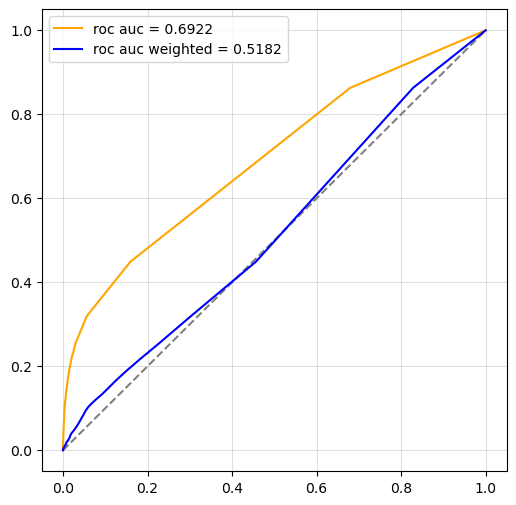

In [81]:
reulst_aft_logreg = tuned_logreg.fit(X_train, y_train)
y_pred_prob = reulst_aft_logreg.predict_proba(X_test)

(
    roc_auc_score(y_train, reulst_aft_logreg.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

In [83]:
(
    roc_auc_score(y_train, reulst_aft_logreg.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

(0.7322697183584244, 0.7047621877917829)

In [82]:
joblib.dump(reulst_aft_logreg, "data/models/aft_3_5_logreg.pickle")

['data/models/aft_3_5_logreg.pickle']

# withoutaft, magn > 3.5

## read 

In [84]:
dataset_type_train = "magn_3_5_withoutaft_train"
dataset_type_test = "magn_3_5_withoutaft_test"

target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

train_path = f"data/dataset/{dataset_type_train}.parquet"
test_path = f"data/dataset/{dataset_type_test}.parquet"

In [85]:
train_df, test_df = utils.get_train_test_datasets(
    train_path=train_path, test_path=test_path, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

train_path: data/dataset/magn_3_5_withoutaft_train.parquet
test_path: data/dataset/magn_3_5_withoutaft_test.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-21 — 2020-10-05
test dates: 2020-10-14 — 2023-05-21

train: target==0: 1129198, target==1: 8402
test: target==0: 4461907, target==1: 41093
target class proportion: test: 0.009209739243780742, train: 0.007440679136874136


In [86]:
feature_cols = list(set(train_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

In [87]:
# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_train, y_train = features.make_features_target(train_df)
X_test, y_test = features.make_features_target(test_df)

In [88]:
y_test.reset_index().merge(y_train.reset_index(), how="left").isna().sum()

dt        0
cell_x    0
cell_y    0
target    0
dtype: int64

In [89]:
# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date)
roc_auc_weights_train = get_weights_for_roc_auc(y=y_train, last_dt=min_test_date)

logisticregression hyperoptimisation:  20%|██        | 1/5 [4:47:01<19:08:06, 17221.57s/it]


In [90]:
assert len(roc_auc_weights_test) == len(roc_auc_weights_test[~np.isnan(roc_auc_weights_test)]) == len(y_test)
assert len(roc_auc_weights_train) == len(roc_auc_weights_train[~np.isnan(roc_auc_weights_train)]) == len(y_train)

In [91]:
len(roc_auc_weights_test[roc_auc_weights_test > 0.0]), np.max(roc_auc_weights_test), np.unique(roc_auc_weights_test)

(4503000,
 1.0,
 array([0.00240385, 0.00480769, 0.00721154, 0.00961538, 0.01201923,
        0.01442308, 0.01682692, 0.01923077, 0.02163462, 0.02403846,
        0.02644231, 0.02884615, 0.03125   , 0.03365385, 0.03605769,
        0.03846154, 0.04086538, 0.04326923, 0.04567308, 0.04807692,
        0.05048077, 0.05288462, 0.05528846, 0.05769231, 0.06009615,
        0.0625    , 0.06490385, 0.06730769, 0.06971154, 0.07211538,
        0.07451923, 0.07692308, 0.07932692, 0.08173077, 0.08413462,
        0.08653846, 0.08894231, 0.09134615, 0.09375   , 0.09615385,
        0.09855769, 0.10096154, 0.10336538, 0.10576923, 0.10817308,
        0.11057692, 0.11298077, 0.11538462, 0.11778846, 0.12019231,
        0.12259615, 0.125     , 0.12740385, 0.12980769, 0.13221154,
        0.13461538, 0.13701923, 0.13942308, 0.14182692, 0.14423077,
        0.14663462, 0.14903846, 0.15144231, 0.15384615, 0.15625   ,
        0.15865385, 0.16105769, 0.16346154, 0.16586538, 0.16826923,
        0.17067308, 0.17307692, 

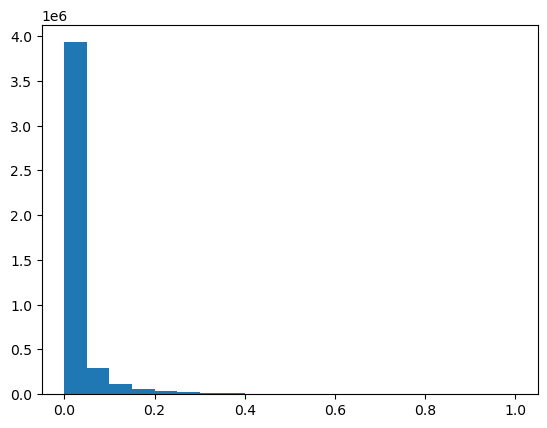

In [92]:
plt.hist(roc_auc_weights_test[roc_auc_weights_test > 0.0], range=(0, 1.0), bins=20);

In [93]:
y_train = y_train[target]
y_test = y_test[target]

In [94]:
y_train.sum(), y_test.sum()

(8402, 41093)

## logreg

In [95]:
cv = utils.MonthlyTimeSeriesSplit(window=20)
cv.get_n_splits(X_train)

3

In [96]:
for split_train, split_test in cv.split(X_train):
    train_start = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    train_end = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]
    test_start = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    test_end = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]

    print(f"train: [{train_start}, {train_end}], len: {len(split_train)} | test: [{test_start}, {test_end}], len: {len(split_test)}")

train: [2014-03-21, 2015-10-22], len: 279660 | test: [2015-11-01, 2017-06-23], len: 289140
train: [2014-03-21, 2017-06-23], len: 568800 | test: [2017-07-03, 2019-02-23], len: 289140
train: [2014-03-21, 2019-02-23], len: 857940 | test: [2019-03-05, 2020-10-05], len: 279660


### baseline

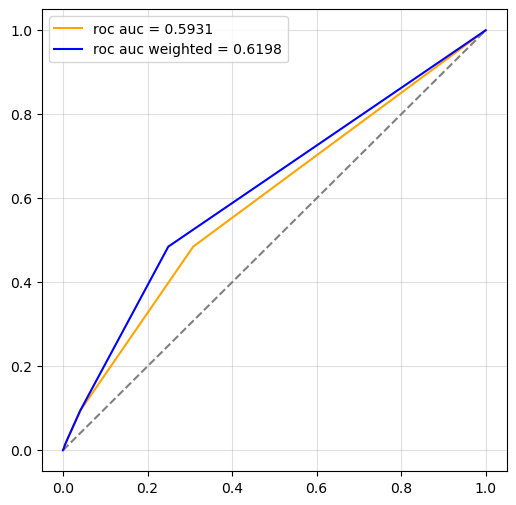

In [97]:
params = {
    "C": 1.0,
    "max_iter": 1500,
}

logreg_model = train.get_logreg_model(feature_cols, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)

baseline_roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

In [100]:
len(np.unique(y_pred_prob[:, 1]))

4503000

In [101]:
(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

(0.7343555780613371, 0.6420150106542636)

### rfecv feature selection

In [116]:
def logreg_rfe_select(X_train, y_train, feature_cols, cv, params=None, min_features_to_select=10, step=5, n_jobs=20):
    if params is None:
        params = {
            "C": 1.0,
            "max_iter": 1500,
        }
    
    preprocesser = get_logreg_preprocesser(feature_cols)
    X_train_transformed = preprocesser.fit_transform(X_train)

    rfecv = RFECV(
        estimator=LogisticRegression(**params),
        step=step,
        cv=cv.split(X_train_transformed),
        scoring="roc_auc",
        min_features_to_select=min_features_to_select,
        n_jobs=n_jobs,
    )

    rfecv = rfecv.fit(X_train_transformed, y_train)
    
    print(f"Optimal number of features: {rfecv.n_features_}")
    selected_features = np.asarray(feature_cols)[rfecv.support_].tolist()
    
    return selected_features

In [117]:
rfecv_features = logreg_rfe_select(
    X_train, y_train, feature_cols, cv, params=None, min_features_to_select=10, step=5, n_jobs=20
)

Optimal number of features: 87


In [118]:
rfecv_features

['min_magn_365_rad5',
 'max_magn_365_rad0',
 'mean_magn_1095_rad5',
 'min_magn_1825_rad0',
 'mean_magn_1825_rad5',
 'min_magn_180_rad5',
 'mean_magn_180_rad0',
 'count_earthquakes_2555_rad0',
 'min_magn_3650_rad0',
 'mean_magn_3650_rad0',
 'mean_magn_1825_rad3',
 'std_magn_180_rad5',
 'std_magn_90_rad5',
 'max_magn_1095_rad5',
 'count_earthquakes_1825_rad3',
 'std_magn_2555_rad3',
 'max_magn_365_rad3',
 'count_earthquakes_180_rad5',
 'mean_magn_2555_rad0',
 'mean_magn_180_rad5',
 'mean_magn_180_rad3',
 'count_earthquakes_60_rad5',
 'max_magn_60_rad0',
 'min_magn_180_rad3',
 'count_earthquakes_2555_rad3',
 'mean_magn_60_rad5',
 'max_magn_1825_rad3',
 'min_magn_90_rad0',
 'max_magn_1095_rad0',
 'std_magn_180_rad3',
 'mean_magn_2555_rad5',
 'std_magn_60_rad3',
 'min_magn_365_rad3',
 'cell_x',
 'count_earthquakes_1825_rad0',
 'max_magn_90_rad0',
 'max_magn_90_rad3',
 'min_magn_1825_rad5',
 'min_magn_60_rad5',
 'std_magn_3650_rad0',
 'std_magn_1825_rad0',
 'min_magn_60_rad3',
 'max_magn_365

In [119]:
utils.get_features_dict(rfecv_features)

{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

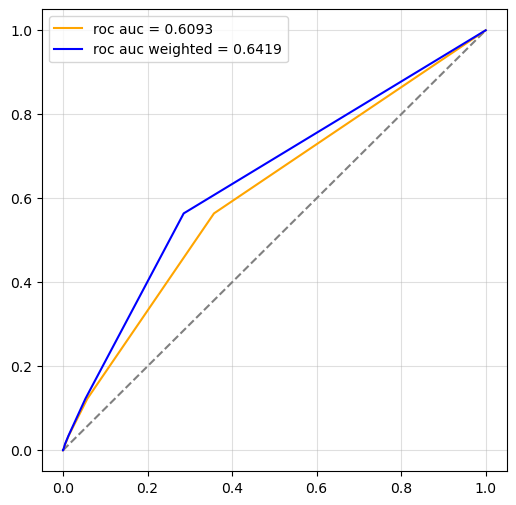

In [120]:
params = {
    "C": 1.0,
    "max_iter": 1500,
}

logreg_model = train.get_logreg_model(rfecv_features, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)


(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

### hyper optimiziation

In [121]:
def fixed_params(**kwargs) -> dict[str, Any]:
    params = {
        "max_iter": 1500,
        "penalty": "l2",
        "random_state": 42,
    }

    params.update(kwargs)

    return params


def default_params(**kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": 1.0,
    }
    params.update(kwargs)

    return params


def suggest_params(trial: optuna.trial.Trial, **kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": trial.suggest_float("C", 0.001, 100.0),
    }
    params.update(kwargs)

    return params

tuned_logreg = train.run_optuna(
    X = X_train,
    y = y_train,
    n_trials = 100,
    dump_study_path = f"data/optuna_res/logreg_{dataset_type_train.replace('_train', '')}",
    seed = 42,
    resume = False,
    suggest_params = suggest_params,
    default_params = default_params,
    cv = utils.MonthlyTimeSeriesSplit(window=20, partition=True),
    model = train.get_logreg_model(rfecv_features, default_params()),
    n_jobs = 20,
    model_name = "logisticregression",
)

using MonthlyTimeSeriesSplit


logisticregression hyperoptimisation:   1%|          | 1/100 [01:11<1:58:18, 71.70s/it]/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the do

In [122]:
tuned_logreg_params = tuned_logreg["logisticregression"].get_params()
tuned_logreg_params

{'C': 17.621449196943164,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


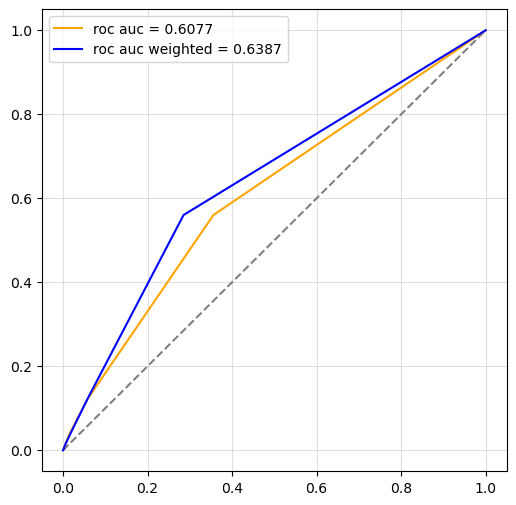

In [123]:
reulst_withoutaft_logreg = tuned_logreg.fit(X_train, y_train)
y_pred_prob = reulst_withoutaft_logreg.predict_proba(X_test)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

In [124]:
(
    roc_auc_score(y_train, reulst_withoutaft_logreg.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

(0.7334124555177455, 0.6420857338373641)

In [125]:
joblib.dump(reulst_withoutaft_logreg, "data/models/withoutaft_3_5_logreg.pickle")

['data/models/withoutaft_3_5_logreg.pickle']